# Exploring Calcium Imaging Data from Macaque Motor Cortex

**⚠️ Note: This notebook was AI-generated with human supervision and has not been fully verified. Please be cautious when interpreting the code or results.**

This notebook demonstrates how to work with calcium imaging data from the supplementary motor area (SMA) and primary motor cortex (M1) of macaque monkeys during spontaneous behavior and arm reaching tasks. The data was collected using one-photon calcium imaging with miniature microscopes.

[DANDI:001174](https://neurosift.app/dandiset/001174) contains calcium imaging recordings from multiple sessions across different behavioral conditions, allowing investigation of neural dynamics during motor behavior.

## Dataset Overview

* **Species**: Macaca mulatta (Rhesus macaque)
* **Brain Regions**: SMA and M1
* **Technique**: One-photon calcium imaging with miniature microscopes
* **Behavior**: Spontaneous activity and arm reaching task
* **Number of Subjects**: 4
* **Data Types**: 
    - Raw fluorescence traces
    - Detected calcium events
    - ROI (cell) spatial footprints

The dataset includes recordings from multiple sessions per animal in both spontaneous and task conditions.

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt

## Loading and Exploring the Data

Let's start by loading a sample session from subject Q during spontaneous behavior.
We'll use lindi to efficiently access the NWB file stored in the DANDI archive.

In [2]:
# Load a sample NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001174/assets/de07db56-e7f3-4809-9972-755c51598e8d/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

print(f"Session description: {nwb.session_description}")
print(f"Subject: {nwb.subject.subject_id} ({nwb.subject.species})")
print(f"Age: {nwb.subject.age}")
print(f"Recording start time: {nwb.session_start_time}")

Session description: Calcium imaging in SMA during the spontaneous condition
Subject: Q (Macaca mulatta)
Age: P5Y
Recording start time: 2022-09-15 13:16:33.129000+00:00


## Examining the Neural Data Structure

The data includes several key components:
1. Fluorescence traces for each identified cell (ROI)
2. Detected calcium events
3. Spatial footprints showing cell locations

Let's look at the basic properties of our recording:

In [3]:
# Get the main data objects
ophys = nwb.processing["ophys"]
fluorescence = ophys["Fluorescence"]["RoiResponseSeries"]
event_amplitude = ophys["EventAmplitude"]
segmentation = ophys["ImageSegmentation"]["PlaneSegmentation"]

print(f"\nNumber of ROIs: {fluorescence.data.shape[1]}")
print(f"Number of timepoints: {fluorescence.data.shape[0]}")
print(f"Sampling rate: {fluorescence.rate:.2f} Hz")
print(f"Recording duration: {fluorescence.data.shape[0]/fluorescence.rate:.2f} seconds")


Number of ROIs: 40
Number of timepoints: 6041
Sampling rate: 10.01 Hz
Recording duration: 603.50 seconds


## Visualizing Neural Activity

Let's look at the calcium activity of some example neurons. We'll plot both the raw fluorescence traces
and the detected calcium events.

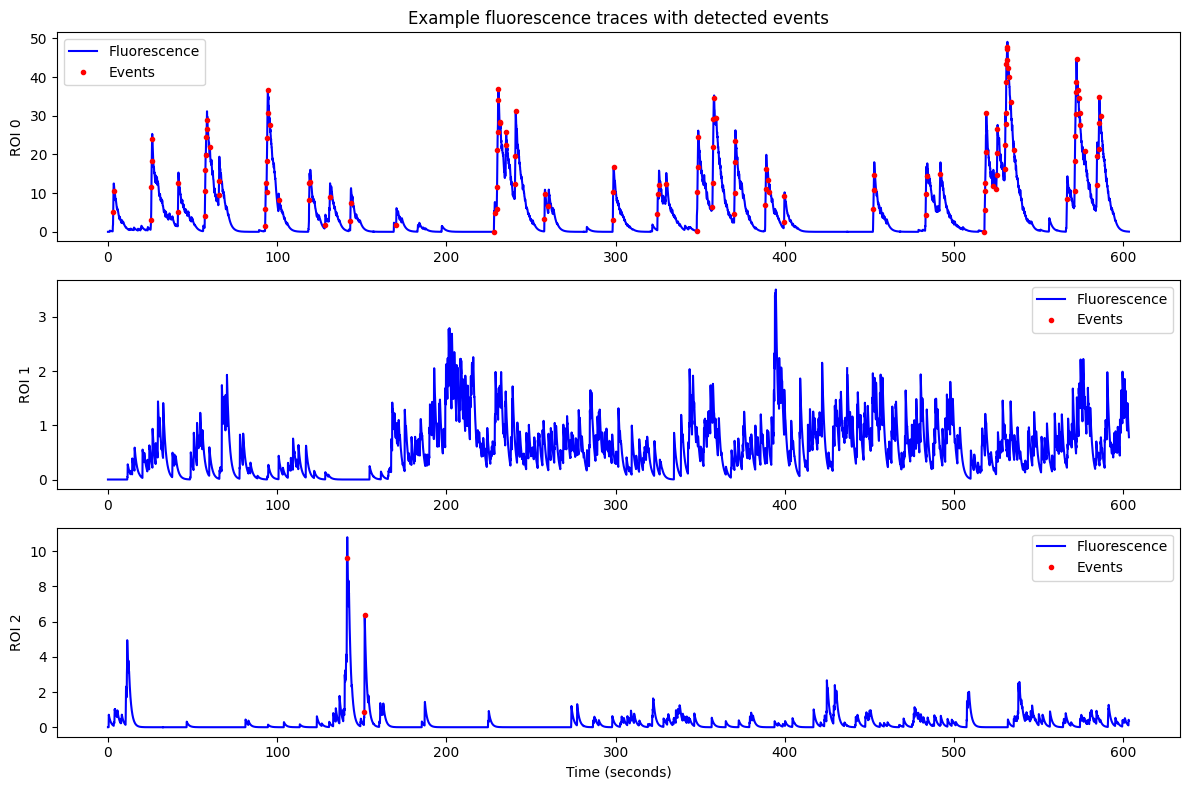

In [4]:
# Plot fluorescence traces for a few example neurons
example_neurons = [0, 1, 2]  # First 3 neurons
time_vec = np.arange(fluorescence.data.shape[0]) / fluorescence.rate

plt.figure(figsize=(12, 8))
for i, n_id in enumerate(example_neurons):
    # Get fluorescence trace
    trace = fluorescence.data[:, n_id]
    # Get event amplitudes
    events = event_amplitude.data[:, n_id]
    
    plt.subplot(len(example_neurons), 1, i+1)
    plt.plot(time_vec, trace, 'b', label='Fluorescence')
    # Mark events with red dots
    event_times = time_vec[events > 0]
    event_values = trace[events > 0]
    plt.plot(event_times, event_values, 'r.', label='Events')
    
    plt.ylabel(f'ROI {n_id}')
    if i == 0:
        plt.title('Example fluorescence traces with detected events')
    if i == len(example_neurons)-1:
        plt.xlabel('Time (seconds)')
    plt.legend()

plt.tight_layout()

In the traces above:
* Blue lines show the raw fluorescence intensity
* Red dots indicate detected calcium events, likely corresponding to periods of increased neural activity
* Each neuron shows distinct patterns of activity

## Spatial Organization of Cells

We can visualize where each cell (ROI) is located in the field of view:

(-0.5, 178.5, 291.5, -0.5)

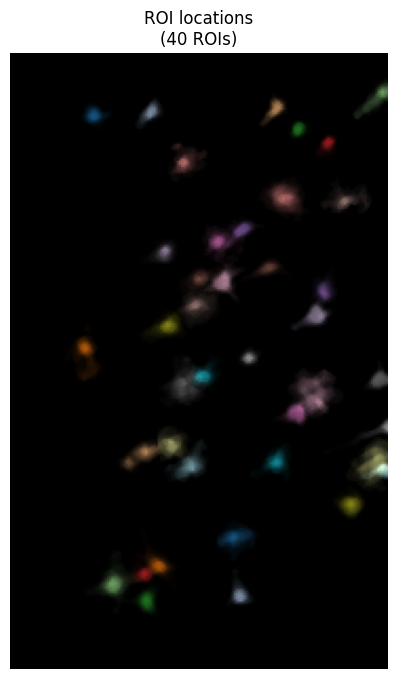

In [5]:
# Plot all ROI footprints in one image
masks = segmentation["image_mask"].data[:]
# Create a composite image where each ROI has a different color
composite = np.zeros(masks[0].shape + (3,))
for i, mask in enumerate(masks):
    # Cycle through some distinct colors
    color = plt.cm.tab20(i % 20)[:3]  # Get RGB values from colormap
    for c in range(3):
        composite[:,:,c] += mask * color[c]

# Normalize to [0,1]
composite /= composite.max()

plt.figure(figsize=(8, 8))
plt.imshow(composite)
plt.title(f'ROI locations\n({len(masks)} ROIs)')
plt.axis('off')

Each color represents a different cell. This visualization shows how the cells are distributed across the
imaging field of view. 

## Comparing Spontaneous and Task Conditions

Now let's load a task session for comparison:


Event Statistics:
                     Spontaneous     Task           
--------------------------------------------------
Duration:         603.3 sec      903.8 sec
Total events:        1419            2021
Active neurons:    36/40           39/40 
Mean rate:        0.059 Hz      0.056 Hz
Median rate:      0.016 Hz      0.023 Hz


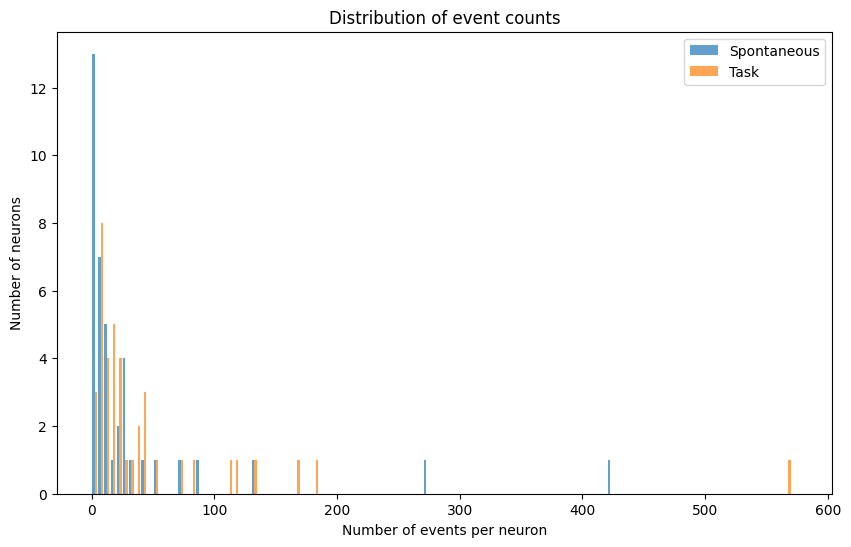

In [6]:
# Load a task session
f_task = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001174/assets/807851a7-ad52-4505-84ee-3b155a5bd2a3/nwb.lindi.json")
nwb_task = pynwb.NWBHDF5IO(file=f_task, mode='r').read()

# Function to analyze events
def analyze_events(events, sampling_rate):
    """Compute various event statistics"""
    duration = events.shape[0] / sampling_rate
    n_neurons = events.shape[1]
    
    # Count events per neuron
    event_counts = np.sum(events > 0, axis=0)
    event_rates = event_counts / duration
    
    # Count total events and active neurons
    total_events = np.sum(event_counts)
    active_neurons = np.sum(event_counts > 0)
    
    return {
        'total_events': total_events,
        'active_neurons': active_neurons,
        'total_neurons': n_neurons,
        'duration': duration,
        'event_counts': event_counts,
        'event_rates': event_rates,
        'mean_rate': np.mean(event_rates),
        'median_rate': np.median(event_rates)
    }

# Analyze both conditions
spont_events = event_amplitude.data[:]
task_events = nwb_task.processing["ophys"]["EventAmplitude"].data[:]

spont_stats = analyze_events(spont_events, event_amplitude.rate)
task_stats = analyze_events(task_events, nwb_task.processing["ophys"]["EventAmplitude"].rate)

# Print summary statistics
print("\nEvent Statistics:")
print(f"{'':20} {'Spontaneous':15} {'Task':15}")
print("-" * 50)
print(f"Duration:         {spont_stats['duration']:.1f} sec      {task_stats['duration']:.1f} sec")
print(f"Total events:     {spont_stats['total_events']:7d}         {task_stats['total_events']:7d}")
print(f"Active neurons:   {spont_stats['active_neurons']:3d}/{spont_stats['total_neurons']:<3d}         {task_stats['active_neurons']:3d}/{task_stats['total_neurons']:<3d}")
print(f"Mean rate:        {spont_stats['mean_rate']:.3f} Hz      {task_stats['mean_rate']:.3f} Hz")
print(f"Median rate:      {spont_stats['median_rate']:.3f} Hz      {task_stats['median_rate']:.3f} Hz")

# Plot event count distribution
plt.figure(figsize=(10, 6))
bins = np.arange(0, max(spont_stats['event_counts'].max(), task_stats['event_counts'].max()) + 10, 5)
plt.hist([spont_stats['event_counts'], task_stats['event_counts']], 
         bins=bins, label=['Spontaneous', 'Task'],
         alpha=0.7)
plt.xlabel('Number of events per neuron')
plt.ylabel('Number of neurons')
plt.title('Distribution of event counts')
plt.legend()

Key observations from comparing spontaneous and task conditions:
* Most neurons are active in both conditions (36/40 in spontaneous, 39/40 in task)
* The overall event rates are similar between conditions
* There's a wide distribution of event counts across neurons, with many neurons showing relatively few events
* The task condition shows slightly higher median event rate, suggesting potentially more consistent activity

Note that this analysis focuses on just two example sessions. For a more comprehensive understanding,
you would want to analyze multiple sessions and perform appropriate statistical tests.

## Working with Your Own Analysis

To adapt this notebook for your own analysis:

1. Use the `dandiset_assets` tool to list available sessions:
```python
from dandischema.models import Dandiset
dandi_id = "001174"
version = "draft"
# List NWB files
assets = get_asset_list(dandi_id, version)
```

2. Choose sessions of interest and modify the lindi URLs accordingly

3. Consider additional analyses such as:
   * Temporal relationships between neural events and behavior
   * Population-level activity patterns
   * Comparison across different recording sites or subjects

4. Remember that the data is hosted remotely, so be mindful of loading large data chunks